We show here how to train the Rhapsody random forest classifier in its final form.

Based on the analyses illustrated in the `RF_optimization` notebook, we will make the following choices:
* the training dataset will only contain SAVs with at least 1 review star in the ClinVar database (when available) and with same clinical interpretation in all 7 datasets
* only PDB structures with at least 150 residues will be considered
* the random forest classifier hyperparameters are set based on the optimization procedure (max. number of features = 2, number of trees in the forest = 1500)
* dynamical features are computed from ANM without environmental effects (`chain` model)

## Importing training dataset

In [1]:
import sys, os
import pickle
import numpy as np
from glob import glob
from prody import LOGGER

In [2]:
# please make sure to extract the data folder beforehand
ID = np.load('../00-Training_Dataset/data/precomputed_features-ID.npy')
len(ID)

91697

In [3]:
# let's discard SAVs with unknown significance (true_label == -1), ...
ID = ID[ID['true_label'] != -1]
len(ID)

87726

In [4]:
# ... SAVs with associated PDB structure smaller than 150 residues ...
ID = ID[ ID['PDB_length' ] >= 150]
len(ID)

23085

In [5]:
# ... and SAVs with 0 review star according to ClinVar
ClinVar_SAVs  = np.load('../00-Training_Dataset/data/ClinVar_Dataset-SAVs.npy')
excluded_SAVs = set(ClinVar_SAVs[ClinVar_SAVs['review_star'] < 1]['SAV_coords'])
ID = ID[ [SAV not in excluded_SAVs for SAV in ID['SAV_coords']] ]
len(ID)

20361

## Training of Random Forest classifier

We train 3 classifiers based on different set of features:

In [6]:
featsets = {
    'v2': [        # full classifier
        'wt_PSIC', 'Delta_PSIC', 'SASA', 
        'ANM_MSF-chain', 'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
        'stiffness-chain', 'entropy', 'ranked_MI', 'BLOSUM'
    ],
    'v2_noPfam': [ # reduced classifier
        'wt_PSIC', 'Delta_PSIC', 'SASA', 
        'ANM_MSF-chain', 'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
        'stiffness-chain', 'BLOSUM'
    ],
    'v2_EVmut': [  # full classifier + EVmutation epistatic score
        'wt_PSIC', 'Delta_PSIC', 'SASA', 
        'ANM_MSF-chain', 'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
        'stiffness-chain', 'entropy', 'ranked_MI', 'BLOSUM', 'EVmut-DeltaE_epist'
    ],
}

In [7]:
# Insert here path to Rhapsody folder
sys.path.insert(0, '/home/lponzoni/Scratch/028-RHAPSODY-git/rhapsody')

from rhapsody import *

In [8]:
if not os.path.isdir('results'):
    os.mkdir('results')

In [9]:
if os.path.isfile('results/RF_training_summaries.pkl'):
    print('A pickle containing precomputed results have been found.')
    print('Please delete it if you wish to run the analysis again.')
else:
    LOGGER.start('results/RF_training.log')
    RF_training_summaries = {}

    for version in ['v2', 'v2_noPfam', 'v2_EVmut']:
        
        featset = ['SAV_coords', 'true_label'] + featsets[version]

        LOGGER.info(f'VERSION: {version}')

        # create folder
        folder = f'results/RF_training-{version}'
        os.mkdir(folder)

        # run training procedure
        output_dict = trainRFclassifier(ID[featset])
        RF_training_summaries[version] = output_dict['CV summary']

        # move trained classifier and figures into folder
        for file in glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(folder, file))

        LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(RF_training_summaries, open('results/RF_training_summaries.pkl', 'wb'))

    LOGGER.close('results/RF_training.log')

@> Logging into file: results/RF_training.log
@> Logging started at 2019-03-15 21:11:43.224632
@> VERSION: v2
@> 3918 out of 20361 cases ignored with missing features.
@> CV iteration # 1:   AUROC = 0.864   AUPRC = 0.925   OOB score = 0.809
@> CV iteration # 2:   AUROC = 0.864   AUPRC = 0.924   OOB score = 0.810
@> CV iteration # 3:   AUROC = 0.844   AUPRC = 0.913   OOB score = 0.813
@> CV iteration # 4:   AUROC = 0.869   AUPRC = 0.929   OOB score = 0.810
@> CV iteration # 5:   AUROC = 0.857   AUPRC = 0.925   OOB score = 0.812
@> CV iteration # 6:   AUROC = 0.851   AUPRC = 0.920   OOB score = 0.813
@> CV iteration # 7:   AUROC = 0.860   AUPRC = 0.924   OOB score = 0.811
@> CV iteration # 8:   AUROC = 0.859   AUPRC = 0.925   OOB score = 0.811
@> CV iteration # 9:   AUROC = 0.847   AUPRC = 0.911   OOB score = 0.810
@> CV iteration #10:   AUROC = 0.850   AUPRC = 0.915   OOB score = 0.812
@> ------------------------------------------------------------
@> Cross-validation summary:
@> traini

In [10]:
# recover precomputed training results
RF_training_summaries = pickle.load(open('results/RF_training_summaries.pkl', 'rb'))

## Comparison with PolyPhen-2 and EVmutation

Let's recover a NumPy array containing predictions from PolyPhen-2:

In [11]:
pph2_predictions = np.load('../00-Training_Dataset/data/PolyPhen2_predictions-ID.npy')
pph2_predictions.dtype

dtype([('SAV_coords', '<U25'), ('prediction', '<U25'), ('pph2_class', '<U25'), ('pph2_prob', '<f4')])

In [12]:
# We select the same subset of the Integrated Dataset as the one used for Rhapsody
pph2_predictions = pph2_predictions[ [SAV in ID['SAV_coords'] for SAV in pph2_predictions['SAV_coords']] ]

In [13]:
# NB: the two arrays should be sorted in the same way
assert all(pph2_predictions['SAV_coords'] == ID['SAV_coords'])

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

pred_scores = {
    'PolyPhen-2' : pph2_predictions['pph2_prob'],
    'EV_mutation': - ID['EVmut-DeltaE_epist']
}

metrics = {}

for method, score in pred_scores.items():
    # let's discard NaN values
    sel = ~np.isnan(score)
    predictions = score[sel]
    true_labels = ID['true_label'][sel]
    
    # Rhapsody contains a function for computing ROC, Precision-Recall curves, etc.
    m = calcMetrics(true_labels, predictions)
    metrics[method] = m
    
    print(f'{method:11}:', f"  n.SAVs = {sum(sel)}", 
          f"   AUROC = {m['AUROC']:.3f}",
          f"   AUPRC = {m['AUPRC']:.3f}")

PolyPhen-2 :   n.SAVs = 20360    AUROC = 0.799    AUPRC = 0.857
EV_mutation:   n.SAVs = 13644    AUROC = 0.808    AUPRC = 0.908


In [15]:
# print summary from Rhapsody training
for v, s in RF_training_summaries.items():
    print(f'{v:11}:', f"  n.SAVs = {s['dataset size']}", 
          f"   AUROC = {s['mean AUROC']:.3f}",
          f"   AUPRC = {s['mean AUPRC']:.3f}",
          f"   OOB score = {s['mean OOB score']:.3f}")

v2         :   n.SAVs = 16443    AUROC = 0.856    AUPRC = 0.921    OOB score = 0.811
v2_noPfam  :   n.SAVs = 20190    AUROC = 0.843    AUPRC = 0.904    OOB score = 0.796
v2_EVmut   :   n.SAVs = 13033    AUROC = 0.854    AUPRC = 0.936    OOB score = 0.833


## Correlation between features

In [16]:
from scipy.stats import spearmanr

correlations = {}

for version in ['v2', 'v2_noPfam', 'v2_EVmut']:

    featset = featsets[version]
    
    X = ID[featset]
    sel = [~np.isnan(np.sum([x for x in r])) for r in X]
    X = X[sel].copy()
    X = X.view((np.float32, len(featset)))
    
    correlations[version] = spearmanr(X)

In [17]:
abbrv = {
    'ANM_MSF-chain': 'MSF',
    'ANM_effectiveness-chain': 'eff',
    'ANM_sensitivity-chain': 'sens',
    'BLOSUM': 'BLSM',
    'Delta_PSIC': 'DPSIC', 
    'EVmut-DeltaE_epist': 'EVmut',
    'SASA': 'SASA',
    'entropy': 'entr',
    'ranked_MI': 'MI',
    'stiffness-chain': 'stf',
    'wt_PSIC': 'wPSIC'}

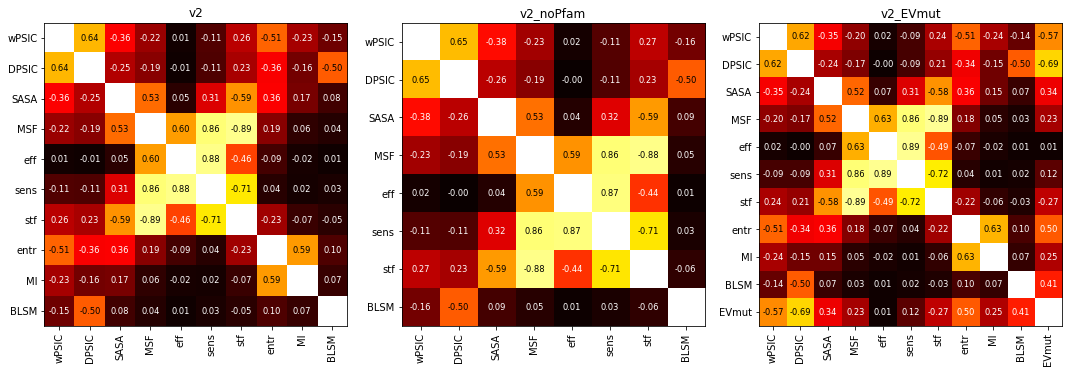

In [18]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (version, Spearm_res) in enumerate(correlations.items()):
    
    m = Spearm_res[0]
    ax = axes[i]
    
    im = ax.imshow(abs(m), cmap='hot', vmin=0, vmax=1)
    ax.set_title(version)
    
    # text annotations
    n = m.shape[0]
    for i in range(n):
        for j in range(n):
            if i==j: continue
            text = ax.text(j, i, f'{m[i, j]:.2f}', ha="center", va="center", 
                           color="w" if abs(m[i, j])<.5 else "k", fontsize='small')
    
    labels = [abbrv[f] for f in featsets[version]]
    ax.set_yticks(range(n))
    ax.set_yticklabels(labels)
    ax.set_xticks(range(n))
    ax.set_xticklabels(labels, rotation='vertical')
    
plt.tight_layout()
fig.savefig('figures/correlation_btw_features.png', dpi=300)

## Leave-one-feature-out analysis

We can assess the relative importance of each feature by looking at their weights in the random forest. An alternative approach is to cross-validate the classifier by leaving out one feature at a time and measure the effect on accuracy.

In [ ]:
if os.path.isfile('results/LOFO_summaries.pkl'):
    print('A pickle containing precomputed results have been found.')
    print('Please delete it if you wish to run the analysis again.')
else:
    LOGGER.start('results/LOFO_analysis.log')
    LOFO_summaries = {}

    for version in ['v2', 'v2_noPfam', 'v2_EVmut']:
        
        LOFO_summaries[version] = {}
        
        featset = featsets[version]

        for f_left_out in featset:

            _featset = ['SAV_coords', 'true_label'] + [f for f in featset if f != f_left_out]

            LOGGER.info(f'VERSION: {version} - FEATURE LEFT OUT: {f_left_out}')

            # create folder
            folder = f'results/LOFO-{version}-{f_left_out}'
            os.mkdir(folder)

            # run cross-validation
            LOFO_summaries[version][f_left_out] = RandomForestCV(ID[_featset])

            # move figures into folder
            for file in glob('*png'):
                os.rename(file, os.path.join(folder, file))

            LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(LOFO_summaries, open('results/LOFO_summaries.pkl', 'wb'))

    LOGGER.close('results/LOFO_analysis.log')

@> Logging into file: results/LOFO_analysis.log
@> Logging started at 2019-03-15 21:21:05.648921
@> VERSION: v2 - FEATURE LEFT OUT: wt_PSIC
@> 3918 out of 20361 cases ignored with missing features.
@> CV iteration # 1:   AUROC = 0.858   AUPRC = 0.918   OOB score = 0.806
@> CV iteration # 2:   AUROC = 0.860   AUPRC = 0.921   OOB score = 0.806
@> CV iteration # 3:   AUROC = 0.836   AUPRC = 0.907   OOB score = 0.808
@> CV iteration # 4:   AUROC = 0.865   AUPRC = 0.926   OOB score = 0.805
@> CV iteration # 5:   AUROC = 0.856   AUPRC = 0.925   OOB score = 0.807
@> CV iteration # 6:   AUROC = 0.843   AUPRC = 0.916   OOB score = 0.809
@> CV iteration # 7:   AUROC = 0.858   AUPRC = 0.924   OOB score = 0.807
@> CV iteration # 8:   AUROC = 0.856   AUPRC = 0.923   OOB score = 0.809
@> CV iteration # 9:   AUROC = 0.837   AUPRC = 0.903   OOB score = 0.809
@> CV iteration #10:   AUROC = 0.838   AUPRC = 0.910   OOB score = 0.811
@> ------------------------------------------------------------
@> Cross

In [ ]:
# recover precomputed results
LOFO_summaries = pickle.load(open('results/RF_training_summaries.pkl', 'rb'))

In [ ]:
print('classifier  feat-left-out            n.SAVs AUROC  AUPRC  OOB')
for version, d in LOFO_summaries.items():
    for feat, s in d.items():
        print(f"{version:10}  {feat:23}  {s['dataset size']}  {s['mean AUROC']:.3f}  " + \
              f"{s['mean AUPRC']:.3f}  {s['mean OOB score']:.3f}" )